In [1]:
cd ../

/home/vlaurent/Project/tools/palma


In [2]:
cd ../..


/home/vlaurent/Project/tools


In [3]:
cd palma/

/home/vlaurent/Project/tools/palma


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection, metrics
from sklearn.datasets import make_classification
from palma import Project, ModelEvaluation, ModelSelector
from palma.components import ScoringAnalysis, ShapAnalysis
from palma.utils import plotting

X, y = make_classification(n_informative=2, n_features=10)
X, y = pd.DataFrame(X), pd.Series(y).astype(bool)

ModuleNotFoundError: No module named 'flaml'

**Create the project**
To create vanilla project (without components), only input data $X$, target data $y$ and validation method needs to be provided

In [7]:
project = Project(problem="classification", project_name="test")
project.start(
    X, y,
    splitter=model_selection.ShuffleSplit(n_splits=4, random_state=42),
)

Here are representation of the validation strategy
* For validation steps
* For test steps

In [8]:
res = plotting.plot_splitting_strategy(
    project.X, project.y, 
    iter_cross_validation=project.validation_strategy.indexes_val, cmap="rainbow_r")

In [9]:
res = plotting.plot_splitting_strategy(
    project.X, project.y, 
    iter_cross_validation=project.validation_strategy.indexes_train_test, cmap="rainbow_r")


**Run Opimization** 
Using the FLAML library, the best model (in a given estimator family) is searched

In [10]:
%%capture
ms = ModelSelector(engine="FlamlOptimizer",
                    engine_parameters=dict(time_budget=5))
ms.start(project)

**Analyse model** Once the best parameters and model is found, use the `ModelEvaluation` api to assess performance. Several built-in component are provided :
- `ScoringAnalysis`
- `RegressionAnalysis`
- `ShapAnalysis`

They can be related to either validation indexes (optimized by `ModelSelector`) or train/test indexes 

In [7]:
model = ModelEvaluation(estimator=ms.best_model_)
model.add(ScoringAnalysis(on="indexes_val"))
model.add(ShapAnalysis(on="indexes_val", n_shap=100))
model.fit(project)

In [8]:
analyser = model.components["ScoringAnalysis"]
shap_analyser = model.components["ShapAnalysis"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


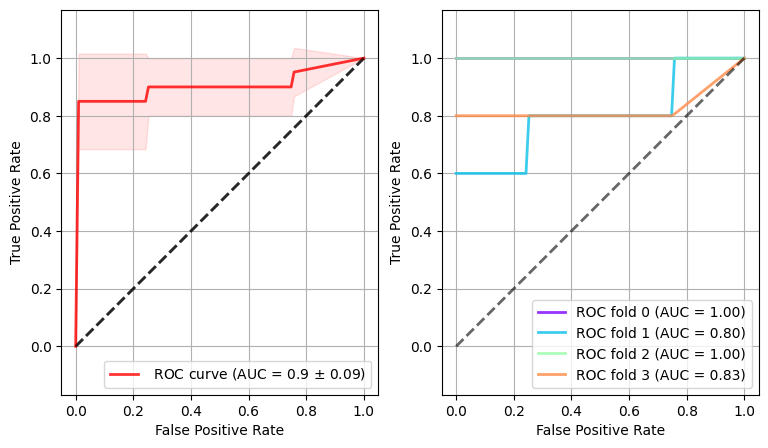

In [29]:

f, ax = plt.subplots(figsize=(9, 5), ncols=2)

plt.sca(ax[0]); 
analyser.plot_roc_curve(plot_method="beam")
analyser.plot_roc_curve(plot_method="mean")
plt.sca(ax[1]); analyser.plot_roc_curve(plot_method="all", cmap="rainbow")
print()

**[FOCUS] Explanantion tools**

1 . variable importance

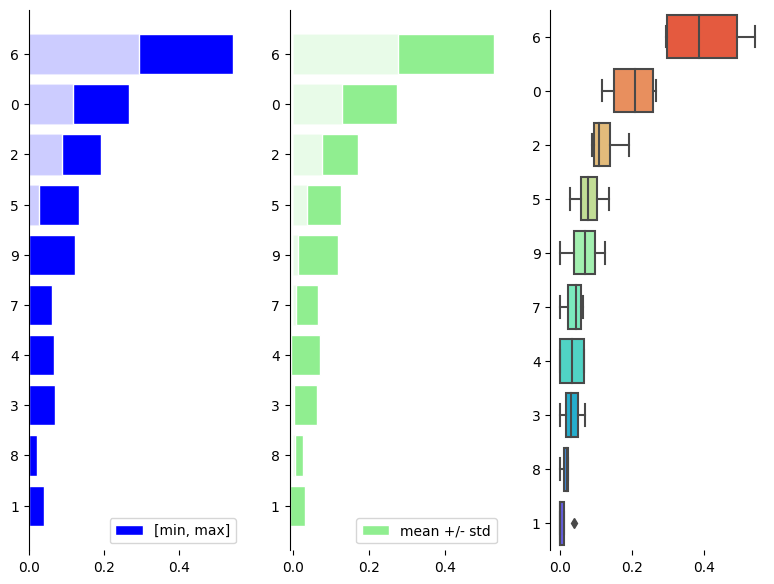

In [10]:
f, ax = plt.subplots(figsize=(8, 6), ncols=3)
plt.sca(ax[0])
analyser.plot_variable_importance(mode="minmax", color="blue")
plt.sca(ax[1])
analyser.plot_variable_importance(mode="std", color="lightgreen")
plt.sca(ax[2])
analyser.plot_variable_importance(mode="boxplot", cmap="rainbow_r")
print()

2. shap explanation 

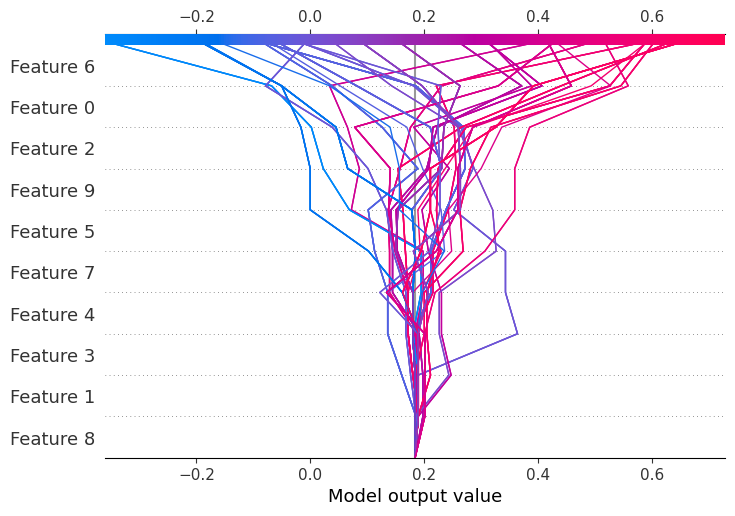

/home/vlaurent/.cache/pypoetry/virtualenvs/ml-toolbox-0oKOZ200-py3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


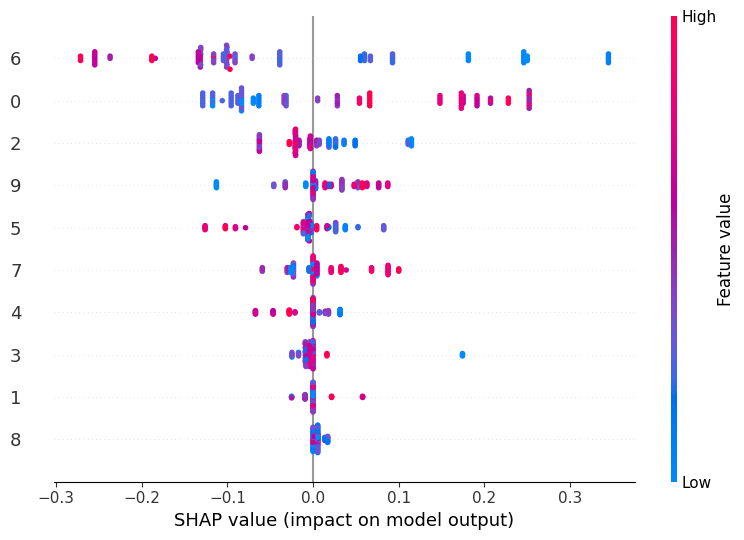

In [11]:
plt.figure(figsize=(5, 5)); shap_analyser.plot_shap_decision_plot()
plt.figure(figsize=(5, 5)); shap_analyser.plot_shap_summary_plot()

**Compute classification threshold**
Three methods are available to set the classification threshold

1. Corresponding to a provided fractile of the population targeted to one
2. Corresponding to a provided fractile of the positive true rate (recall) targeted to one
3. Corresponding to the optimized value of a provided metric

In [19]:
print(analyser.compute_threshold(method="total_population", value=0.5))
print(analyser.compute_threshold(method="fpr",value=0.5))
print(analyser.compute_threshold(method="optimize_metric",  metric=metrics.accuracy_score))

0.18389864074919016
0.40592154217899074
0.0


**Confusion matrix** corresponding to target 50% of the total population

In [30]:
analyser.compute_threshold(method="total_population", value=0.5)
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,10.0,40.0
real : 1,6.7,43.3


**Confusion matrix** corresponding to an accpetance of 50% of false positive rate 

In [31]:
analyser.compute_threshold(method="fpr",value=0.5)
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,33.3,13.3
real : 1,10.0,43.3


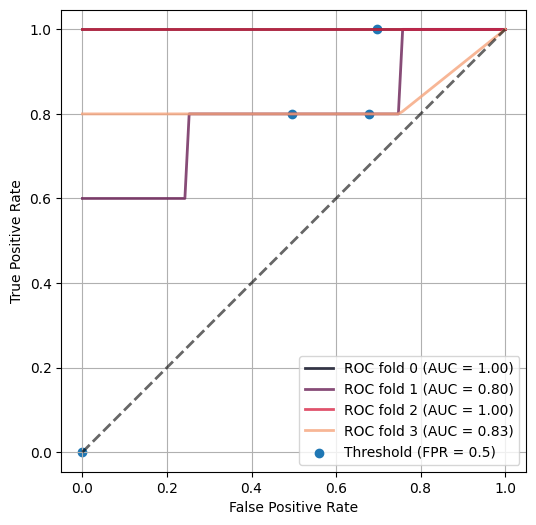

In [32]:
plt.figure(figsize=(6, 6))

analyser.plot_roc_curve(plot_method="all", cmap="rocket")
analyser.plot_threshold(label="Threshold (FPR = 0.5)")
plt.legend(loc=4)